In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.1
numpy 2.2.4
pandas 2.2.3
sklearn 1.6.1
torch 2.7.0+cpu
cpu


In [69]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# 转化成张量并且进行归一化
transform = transforms.Compose([
    ToTensor()
])

# train=true是加载训练集
train_ds = datasets.FashionMNIST(root='../chapter_2_torch/data', train=True, transform=transform, download=True)

#加载测试集
test_ds = datasets.FashionMNIST(root='../chapter_2_torch/data', train=False, transform=transform, download=True)



**训练集，验证集，测试集，之所以要分出来验证集是因为深度学习的能力很强，在调整参数的过程其实就是泄露了数据，所以测试集现在用来在上线时测试模型的表现，就是一锤子买卖，不能再进行调整参数了**

In [70]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [71]:
len(train_ds)

60000

In [72]:
train_ds.data.shape

torch.Size([60000, 28, 28])

In [73]:
type(train_ds.data)

torch.Tensor

In [74]:
print(train_ds.train_labels.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [75]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape
# img.shape = (1, 28, 28)，这是因为通道数在最前面

torch.Size([1, 28, 28])

In [76]:
print(label)

9


In [77]:
type(img)

torch.Tensor

In [78]:
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [79]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)

    print("图像大小:", img.size)
    print("图像模式:", img.mode)

    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)


show_img_content(img)  #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: <built-in method size of Tensor object at 0x000002798382E170>
图像模式: <built-in method mode of Tensor object at 0x000002798382E170>


TypeError: Invalid shape (1, 28, 28) for image data

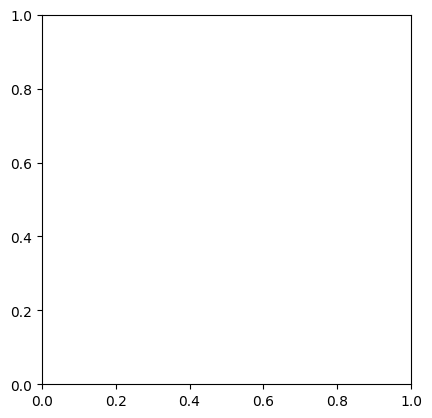

In [80]:
#这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")  # 显示图片
    plt.colorbar()  # 显示颜色条
    plt.show()


show_single_image(img)

In [ ]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            img, label = train_ds[index]
            img = np.transpose(img, (1, 2, 0))  # 通道换到最后一维
            print(img.shape)
            plt.imshow(img, cmap="binary",
                       interpolation = 'nearest')#interpolation='nearest'是临近插值
            plt.axis('off')#去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()
    
    

#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)


In [ ]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

在`PyTorch`中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



# 定义模型

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()
        # 将一张图片展平
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),# 激活函数，如果x > 0 则为x， 否则为0
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork()

In [ ]:
model

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

In [ ]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,

# 训练
pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [81]:
# 定义损失函数
loss_fct = nn.CrossEntropyLoss() # 内部先做了softmax，然后计算交叉熵
# 定义优化器，采用SGD
# 随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [85]:
from sklearn.metrics import accuracy_score

# 临时禁用梯度计算节省内存加速计算
@torch.no_grad()
def evaluating(model, data_loader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in data_loader:
        datas = datas.to(device) # 转到GPU
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)
        loss_list.append(loss.item())
        # 验证集预测返回最大值的索引
        pred = logits.argmax(axis=-1)
        pred_list.extend(pred.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
    # 计算准确率
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

# 训练

In [86]:
def training(model, train_loader, val_loader, epoch, loss_fct,optimizer, eval_step):
    record_dict = {
        "train":[],
        "val": []
    }
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device) #datas尺寸是[batch_size,1,28,28]
                labels = labels.to(device) #labels尺寸是[batch_size]
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step() #梯度是计算并存储在模型参数的 .grad 属性中，优化器使用这些存储的梯度来更新模型参数

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值,一个数值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                }) # 记录训练集信息，每一步的损失，准确率，步数
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 进入评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 进入训练模式

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 20 #改为40
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [87]:
record["train"][-5:]

[{'loss': 0.20618127286434174, 'acc': 0.90625, 'step': 37495},
 {'loss': 0.4165700376033783, 'acc': 0.8125, 'step': 37496},
 {'loss': 0.33572226762771606, 'acc': 0.84375, 'step': 37497},
 {'loss': 0.2562563419342041, 'acc': 0.9375, 'step': 37498},
 {'loss': 0.2960897386074066, 'acc': 0.90625, 'step': 37499}]

In [88]:
record["val"][-5:]

[{'loss': np.float64(0.3648016456121835), 'acc': 0.8668, 'step': 33000},
 {'loss': np.float64(0.3572585197588125), 'acc': 0.8701, 'step': 34000},
 {'loss': np.float64(0.3582308352374421), 'acc': 0.8701, 'step': 35000},
 {'loss': np.float64(0.36725849999834936), 'acc': 0.8688, 'step': 36000},
 {'loss': np.float64(0.3550871053038123), 'acc': 0.8709, 'step': 37000}]

step
0        0.21875
1000     0.71875
2000     0.59375
3000     0.90625
4000     0.90625
5000     0.75000
6000     0.81250
7000     0.78125
8000     0.84375
9000     0.90625
10000    0.87500
11000    0.87500
12000    0.87500
13000    0.87500
14000    0.84375
15000    0.90625
16000    0.90625
17000    0.84375
18000    0.78125
19000    0.75000
20000    0.90625
21000    0.87500
22000    0.87500
23000    0.87500
24000    0.90625
25000    0.90625
26000    0.81250
27000    0.87500
28000    0.78125
29000    0.93750
30000    0.87500
31000    0.87500
32000    0.84375
33000    0.81250
34000    0.90625
35000    0.96875
36000    0.90625
37000    0.78125
Name: acc, dtype: float64
step
0        0.1020
1000     0.6841
2000     0.7679
3000     0.8008
4000     0.8142
5000     0.8166
6000     0.8296
7000     0.8307
8000     0.8350
9000     0.8337
10000    0.8397
11000    0.8446
12000    0.8471
13000    0.8439
14000    0.8516
15000    0.8523
16000    0.8531
17000    0.8571
18000    0.8584
19000    0.856

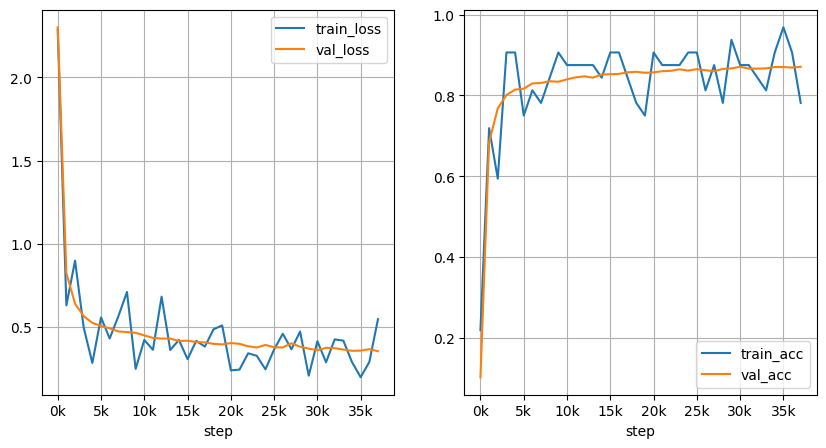

In [97]:
def plot_learning_curve(record_dict, sample_step=1000):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step] # 指定步数切片
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1] # 最后一步的步数
    print(train_df['acc'])
    print(val_df['acc'])
    # plot
    fig_num = len(train_df.columns)
    # 返回的是画布和子图数组，里面存放的是子图对象
    fig, axs = plt.subplots(1, fig_num, figsize = (fig_num * 5, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")  
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curve(record)

# 评估

In [98]:
# 进入评估模式
model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss: {loss}, acc: {acc}")

loss: 0.36706404468883724, acc: 0.8702
